# Preparation

#### Decisions

There are many decisions that you can make that will affect how the model will perform.

The data:
- Train/Test/Split percentages can be changed in the Preparation/Constants section
- Data augmentation transforms and pre-process transforms of the data can be changed in `process.py`

The model:
- Hyperparameters can be changed in the Preparation/Constants section
- Which model we base our transfer learning from can be changed in the "Define Model" section
  - Examples: Resnet34, Resnet50, Resnet101, Densenet121
- The final layer of the model can be changed in the "Define Model" section
    - It should map from number of features to number of classes
    - Example:  
            torch.nn.Sequential(
                torch.nn.Linear(num_features, 1024),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(1024, 512),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(512, NUM_CLASSES)
            )
- The optimizer can be changed in the "Define Model" section
  - Examples:
    - `optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)`
    - `optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)`
- An optional scheduler can be added in the "Define Model" section
  - Example:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='max',
                                                       factor=LR_PLATEAU_FACTOR,
                                                       threshold=LR_PLATEAU_THRESHOLD,
                                                       patience=LR_PLATEAU_PATIENCE,
                                                       verbose=True)
    - `scheduler.step(valid_accuracy)` should be called every epoch

#### Google Colab

If you are using Google Colab, run the cell below and make sure your runtime is using GPU.

If you are not, do not run the cell below and update the `ROOT_PATH` in the `Preparation/Imports` section. Also, if you do not have a GPU to use, comment out the lines that say `cuda`.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Imports

In [31]:
ROOT_PATH = '/content/drive/My Drive'

# to import custom python files, append the path to sys here
import sys
sys.path.append(ROOT_PATH)
from util import process

from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import random

#### Constants

In [32]:
DATA_PATH = f'{ROOT_PATH}/combined_car_data'
NUM_STANFORD_CLASSES = 196
NUM_NEW_CLASSES = 10 * 4
NUM_CLASSES = NUM_STANFORD_CLASSES + NUM_NEW_CLASSES

# which checkpoint am I retraining from?
CHECKPOINT_PATH = f'{ROOT_PATH}/Colab Notebooks/resnet34-89/checkpoint.pth'

TRAIN_PERCENT = 0.8
VALID_PERCENT = 0.1
TEST_PERCENT = 0.1

# hyperparameters
MAX_EPOCHS = 1000
MAX_VALID_ACCURACY_DECREASE = 0.001
BATCH_SIZE = 32
LEARNING_RATE = 0.001
MOMENTUM = 0.9
LR_PLATEAU_FACTOR = 0.1
LR_PLATEAU_THRESHOLD = 0.9
LR_PLATEAU_PATIENCE = 3

# Load Datasets

In [33]:
# define a custom dataset for different transforms
# https://discuss.pytorch.org/t/changing-transformation-applied-to-data-during-training/15671/5
class CustomTransformDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self._dataset = dataset
        self._transform = transform
    
    def __getitem__(self, index):
        image = self._dataset[index][0]
        label = self._dataset[index][1]
        return self._transform(image), label
    
    def __len__(self):
        return len(self._dataset)


In [34]:
# fix the seed for reproducability
seed = (int)(random.random() * 10000)
torch.manual_seed(seed)

print(seed)

9959


In [35]:
# load datasets using ImageFolder structure
dataset = datasets.ImageFolder(DATA_PATH)

# create train, validation, test split
train_split = (int)(TRAIN_PERCENT * len(dataset))
valid_split = (int)(VALID_PERCENT * len(dataset))
test_split = (int)(TEST_PERCENT * len(dataset))
leftover = len(dataset) - train_split - valid_split - test_split
train_split += leftover
train_data, valid_data, test_data = torch.utils.data.random_split(dataset, [train_split, valid_split, test_split])

# set transforms
train_data = CustomTransformDataset(train_data, process.DATA_AUGMENT_TRANSFORM)
valid_data = CustomTransformDataset(valid_data, process.PREPROCESS_TRANSFORM)
test_data = CustomTransformDataset(test_data, process.PREPROCESS_TRANSFORM)

# create data loaders using datasets, set shuffle to true so epochs are different
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)

print(next(iter(train_loader)))

[tensor([[[[ 0.7961,  0.8039,  0.7961,  ...,  0.4118,  0.3961,  0.3961],
          [ 0.8039,  0.8039,  0.8039,  ...,  0.4118,  0.3961,  0.3961],
          [ 0.8118,  0.8196,  0.8118,  ...,  0.4196,  0.4039,  0.4039],
          ...,
          [ 0.2627,  0.2706,  0.2863,  ...,  0.1765,  0.1765,  0.1451],
          [ 0.2706,  0.2784,  0.2784,  ...,  0.1686,  0.1686,  0.1373],
          [ 0.2471,  0.2549,  0.2471,  ...,  0.1686,  0.1686,  0.1294]],

         [[ 0.8275,  0.8353,  0.8275,  ...,  0.7098,  0.7020,  0.7020],
          [ 0.8353,  0.8353,  0.8353,  ...,  0.7098,  0.7020,  0.7020],
          [ 0.8275,  0.8353,  0.8275,  ...,  0.7176,  0.7098,  0.7098],
          ...,
          [ 0.2392,  0.2471,  0.2627,  ...,  0.1765,  0.1765,  0.1451],
          [ 0.2471,  0.2549,  0.2549,  ...,  0.1686,  0.1686,  0.1373],
          [ 0.2235,  0.2314,  0.2235,  ...,  0.1686,  0.1686,  0.1294]],

         [[ 0.8510,  0.8588,  0.8510,  ...,  0.9216,  0.9294,  0.9294],
          [ 0.8588,  0.8588, 

# Set Up Model

In [36]:
# transfer learning using pretrained model
# considering densenet121, resnet34, resnet50, resnet101
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, NUM_STANFORD_CLASSES)

# load checkpoint from original car classifier model
checkpoint = torch.load(CHECKPOINT_PATH)
model.load_state_dict(checkpoint['state_dict'], strict=False)

# freeze the model
# for param in model.parameters():
#     param.requires_grad = False

# define the last fully-connected layer to be a linear transformation from num_features to num_classes
# model.fc = torch.nn.Sequential(
#     torch.nn.Linear(num_features, 1024),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(1024, 512),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(512, NUM_CLASSES)
# )

# redefine last layer for new num of classes
model.fc = torch.nn.Linear(num_features, NUM_CLASSES)

# define the criterion as the cross entropy loss function
criterion = torch.nn.CrossEntropyLoss()

# use the gpu
model.cuda()
criterion.cuda()

# define the stochastic gradient descent with the learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# lower the learning rate as we stop improving, lr = lr * factor
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='max',
                                                       factor=LR_PLATEAU_FACTOR,
                                                       threshold=LR_PLATEAU_THRESHOLD,
                                                       patience=LR_PLATEAU_PATIENCE,
                                                       verbose=True)

# Train Model

#### Validation/Training Function

In [37]:
# run function for both training and validation
def run(model, loader, criterion, train=False):
    # switch to train mode or eval mode
    if train:
        model.train()
    else:
        model.eval()

    losses = []
    predictions_list = []
    targets_list = []

    # iterate over batches of validation data
    for images, labels in tqdm(loader):
        # move images and labels to gpu
        images, labels = images.cuda(), labels.cuda()

        if train:
            # zero out accumulated parameter gradients before doing back propagation 
            optimizer.zero_grad()

            outputs = model.forward(images)

            # back propagate the loss from the loss function to each parameter
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                outputs = model.forward(images)
            loss = criterion(outputs, labels)
  
        # sum the losses
        losses.append(criterion(outputs, labels).item())
  
        # get the probability tensor by undoing log of loss function
        probability = torch.exp(outputs)

        # get the predictions
        predictions = probability.max(dim=1)[1]

        predictions_list.append(predictions.cpu())
        targets_list.append(labels.cpu().data)

    accuracies = []
    for idx in range(len(predictions_list)):
        accuracies.append(accuracy_score(targets_list[idx], predictions_list[idx]))

    accuracy = np.average(accuracies)
    loss = np.average(losses)
    
    return loss, accuracy

#### Training

In [38]:
epoch = 0
max_valid_accuracy = 0
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
while epoch < MAX_EPOCHS:
    train_loss, train_accuracy = run(model, train_loader, criterion, train=True)
    valid_loss, valid_accuracy = run(model, valid_loader, criterion)
    
    # print each epoch
    print(f'\n\
    Epoch #{epoch + 1}\n\
    Training Loss: {train_loss : .3f}\t\
    Training Accuracy: {train_accuracy * 100 : .3f}%\n\
    Validation Loss: {valid_loss : .3f}\t\
    Validation Accuracy: {valid_accuracy * 100 : .3f}%\n')

    # save stats for graph
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    epoch += 1

    # slow the learning rate according to validation accuracy
    scheduler.step(valid_accuracy)

    # stop early if validation accuracy decreased
    accuracy_decrease = max_valid_accuracy - valid_accuracy
    if accuracy_decrease > MAX_VALID_ACCURACY_DECREASE:
        break
    max_valid_accuracy = max(valid_accuracy, max_valid_accuracy)

  2%|▏         | 17/726 [00:22<14:51,  1.26s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
  0%|          | 0/726 [00:00<?, ?it/s]


    Epoch #1
    Training Loss:  3.104	    Training Accuracy:  35.625%
    Validation Loss:  1.468	    Validation Accuracy:  63.709%



  0%|          | 0/726 [00:00<?, ?it/s]


    Epoch #2
    Training Loss:  1.225	    Training Accuracy:  68.575%
    Validation Loss:  0.907	    Validation Accuracy:  69.753%



  0%|          | 0/726 [00:00<?, ?it/s]


    Epoch #3
    Training Loss:  0.863	    Training Accuracy:  72.796%
    Validation Loss:  0.784	    Validation Accuracy:  71.092%



  0%|          | 0/726 [00:00<?, ?it/s]


    Epoch #4
    Training Loss:  0.720	    Training Accuracy:  75.398%
    Validation Loss:  0.709	    Validation Accuracy:  73.221%



  0%|          | 0/726 [00:00<?, ?it/s]


    Epoch #5
    Training Loss:  0.628	    Training Accuracy:  77.423%
    Validation Loss:  0.690	    Validation Accuracy:  73.393%

Epoch     5: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/726 [00:00<?, ?it/s]


    Epoch #6
    Training Loss:  0.545	    Training Accuracy:  81.256%
    Validation Loss:  0.671	    Validation Accuracy:  73.805%



  0%|          | 0/726 [00:00<?, ?it/s]


    Epoch #7
    Training Loss:  0.535	    Training Accuracy:  81.594%
    Validation Loss:  0.668	    Validation Accuracy:  73.798%



  0%|          | 0/726 [00:00<?, ?it/s]


    Epoch #8
    Training Loss:  0.525	    Training Accuracy:  82.102%
    Validation Loss:  0.667	    Validation Accuracy:  74.038%



  0%|          | 0/726 [00:00<?, ?it/s]


    Epoch #9
    Training Loss:  0.519	    Training Accuracy:  82.158%
    Validation Loss:  0.664	    Validation Accuracy:  74.718%

Epoch     9: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 91/91 [01:36<00:00,  1.06s/it]


    Epoch #10
    Training Loss:  0.509	    Training Accuracy:  82.840%
    Validation Loss:  0.666	    Validation Accuracy:  74.155%



# Test Model

#### Plot Training Results

In [39]:
def plot_data(labels, types, x1, y1, x2=None, y2=None, legend=None):
    plt.figure()
    p1 = plt.plot(x1, y1, types[0])
    if x2 is not None:
        p2 = plt.plot(x2, y2, types[1])

    #add title, legend and axes labels
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    
    if x2 is not None and legend is not None:
        plt.legend((p1[0], p2[0]), legend)

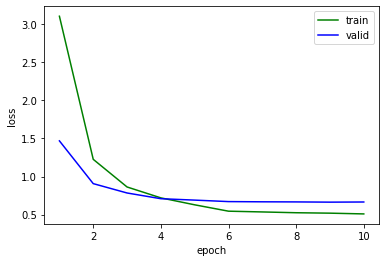

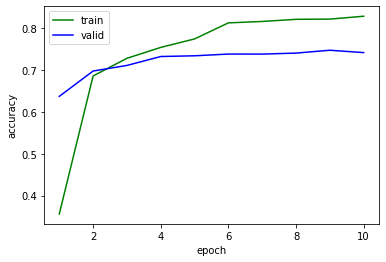

In [40]:
epochs = range(1, epoch + 1)
plot_data(['epoch', 'loss'],
          ['g', 'b'],
          epochs, train_losses,
          epochs, valid_losses,
          ['train', 'valid'])
plot_data(['epoch', 'accuracy'],
          ['g', 'b'],
          epochs, train_accuracies,
          epochs, valid_accuracies,
          ['train', 'valid'])
plt.show()

#### Test Accuracy of Holdout Set

In [41]:
test_loss, test_accuracy = run(model, test_loader, criterion)

print(f'\nTest accuracy of model: {test_accuracy * 100}%')

  2%|▏         | 2/91 [00:01<01:24,  1.05it/s]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 91/91 [01:41<00:00,  1.12s/it]


Test accuracy of model: 73.44093406593406%


# Save Model

In [42]:
# save the feature weights state, new fully connected layer, class-to-index map, sgd state, and number of epochs
checkpoint = {'state_dict': model.state_dict(),
              'model': model.fc,
              'class_to_idx': dataset.class_to_idx,
              'opt_state': optimizer.state_dict,
              'num_epochs': epoch
              }

torch.save(checkpoint, f'{ROOT_PATH}/checkpoint.pth')

# Sources

All code in this journal was adapted from these sources:
- https://github.com/wengsengh/Car-Models-Classifier/blob/master/car_models_classifier.ipynb
- https://www.analyticsvidhya.com/blog/2019/10/how-to-master-transfer-learning-using-pytorch/
- https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/
- https://towardsdatascience.com/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7